In [2]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib 
import seaborn as sns
from wordcloud import WordCloud
import nltk
#nltk.download('stopwords')
import matplotlib.pyplot as plt
from unicodedata import normalize
import re
from sklearn import tree
from sklearn.model_selection import train_test_split

In [3]:
base = pd.read_csv('features-training-0013.csv')
#base = pd.read_csv('features-test-splitted/features-test-0013.csv')
target = pd.read_csv('target-training-0013.csv')
renda = pd.read_excel('renda_per_capita.xlsx')
base_price = base.merge(target, how='left', on = 'id')

In [4]:
def extract_suites(dataframe):
    dataframe2 = dataframe.copy()
    dataframe2.description = dataframe2.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    dataframe2.description = dataframe2.description.str.replace('[^0-9a-zA-Z]', ' ').str.lower()
    dataframe2.description = dataframe2.description.str.replace(' +', ' ')
    dataframe2 = dataframe2[dataframe2.description.str.find('suite')>0]
    dataframe2['inicio'] = dataframe2.description.str.find('suite')
    dataframe2['suites'] = dataframe2.apply(lambda x: x['description'][x['inicio']-2:x['inicio']-1], axis=1)
    dataframe2 = dataframe2[dataframe2.suites.isin(['1', '2', '3', '4', '5', '6'])]
    dataframe2.suites = dataframe2.suites.astype(float)

    dataframe = dataframe.merge(dataframe2[['property_id','suites']], how='left', on = 'property_id')
    dataframe.suites = dataframe.suites.fillna(1)
    return dataframe
    

def extract_vagas(dataframe):
    dataframe2 = dataframe.copy()
    dataframe2.description = dataframe2.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    dataframe2.description = dataframe2.description.str.replace('[^0-9a-zA-Z]', ' ').str.lower()
    dataframe2.description = dataframe2.description.str.replace(' +', ' ')

    #verifica se aparece o numero de vagas no formato "x vagas"
    dataframe_vaga = dataframe2[dataframe2.description.str.find('vaga')>0].copy()
    dataframe_vaga['inicio1'] = dataframe_vaga.description.str.find('vaga')
    dataframe_vaga['vagas1'] = dataframe_vaga.apply(lambda x: x['description'][x['inicio1']-2:x['inicio1']-1], axis=1)
    dataframe_vaga = dataframe_vaga[dataframe_vaga.vagas1.isin(['1', '2', '3', '4', '5', '6'])]

    #verifica se aparece o numero de vagas no formato "x carros"
    dataframe_carro = dataframe2[dataframe2.description.str.find('carro')>0].copy()
    dataframe_carro['inicio2'] = dataframe_carro.description.str.find('carro')
    dataframe_carro['vagas2'] = dataframe_carro.apply(lambda x: x['description'][x['inicio2']-2:x['inicio2']-1], axis=1)
    dataframe_carro = dataframe_carro[dataframe_carro.vagas2.isin(['1', '2', '3', '4', '5', '6'])]

    dataframe = dataframe.merge(dataframe_vaga[['property_id','vagas1']], how='left', on = 'property_id')
    dataframe = dataframe.merge(dataframe_carro[['property_id','vagas2']], how='left', on = 'property_id')

    dataframe['vagas'] = np.where(dataframe.vagas2.isnull(), dataframe.vagas1, dataframe.vagas2)
    dataframe['vagas'] = dataframe.vagas.fillna(1)   #preenche NA com 1 vaga
    dataframe['vagas'] = dataframe.vagas.astype(float)

    dataframe.drop(['vagas1', 'vagas2'], inplace=True, axis=1)
    return dataframe



#verifica se imóvel possui piscina. 2430 imoveis tem piscina
def extract_piscina(dataframe):
    dataframe2 = dataframe.copy()
    dataframe2.description = dataframe2.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    dataframe2.description = dataframe2.description.str.replace('[^0-9a-zA-Z]', ' ')
    dataframe2.description = dataframe2.description.str.replace(' +', ' ').str.lower()
    dataframe['piscina'] = np.where(dataframe2.description.str.find('piscina')>0, 1, 0)
    return dataframe


# extrai o número de quartos da coluna description
def extract_rooms(dataframe):
    
    quarto_null = dataframe.copy()
    quarto_null.description = quarto_null.description.apply(lambda x: normalize('NFKD', x).encode('ASCII','ignore').decode('ASCII')) #remove acento
    quarto_null.description = quarto_null.description.str.replace('[^0-9a-zA-Z]', ' ') #deixa só numero e letra
    quarto_null.description = quarto_null.description.str.replace(' +', ' ')
    quarto_null.description = quarto_null.description.str.lower().str.replace('dormitorio|dormitório|dormitrio|dorm', 'quarto')
    quarto_null = quarto_null[quarto_null.description.str.find('quarto')>0]
    quarto_null['inicio'] = quarto_null.description.str.lower().str.find('quarto')
    quarto_null['rooms'] = quarto_null.apply(lambda x: x['description'][x['inicio']-2:x['inicio']-1], axis=1)
    quarto_null = quarto_null[quarto_null.rooms.isin(['1', '2', '3', '4', '5', '6'])]
    quarto_null.rooms = quarto_null.rooms.astype(float)
    dataframe = dataframe.merge(quarto_null[['property_id','rooms']], how='left', on = 'property_id')
    dataframe.rooms_x = np.where(dataframe.rooms_y.isnull(), dataframe.rooms_x, dataframe.rooms_y)
    dataframe.rename(columns = {'rooms_x': 'rooms'}, inplace = True) 
    dataframe.drop(['rooms_y'], inplace=True, axis=1)
    for i in dataframe.property_type.unique():
        y = dataframe.rooms[dataframe.property_type==i]
        dataframe['rooms'] = np.where((dataframe.rooms.isnull()) & (dataframe.property_type==i), y.median(), dataframe.rooms)
        dataframe['rooms'] = np.where((dataframe.rooms > 6) & (dataframe.property_type==i), y.median(), dataframe.rooms)
    dataframe['rooms'] = np.where((dataframe.property_type=='store'), 0, dataframe.rooms) #atribui 0 para quando é store
   
    return dataframe

## Agrupar o tratamento da base dentro de uma função

def process_base(dataframe):
  
    dataframe = dataframe[dataframe.currency=='BRL'].copy()
    dataframe['city_name'] = dataframe['place_with_parent_names'].str.split("|", n = 4, expand = True)[3]
    columns = ['operation', 'geonames_id', 'lat_lon', 'image_thumbnail', 'floor', 'currency', 'country_name', 'id', 'collected_on', 'place_with_parent_names', 'lat', 'lon', 'surface_total_in_m2', 'expenses' ]
    dataframe.drop(columns, inplace=True, axis=1)
    dataframe = dataframe.drop_duplicates('property_id', keep = 'last')
    dataframe.created_on = pd.to_datetime(dataframe.created_on, format="%Y-%m-%d") #formata data
    dataframe = extract_rooms(dataframe) #extrai nº de quartos
    dataframe = extract_piscina(dataframe) #tem ou não piscina
    dataframe = extract_vagas(dataframe)
    dataframe = extract_suites(dataframe)
    for i in dataframe.property_type.unique():
        y = dataframe.surface_covered_in_m2[dataframe.property_type==i]
        dataframe['surface_covered_in_m2'] = np.where((dataframe.surface_covered_in_m2 > y.quantile(q=0.85)) & (dataframe.property_type==i), y.median(), dataframe.surface_covered_in_m2)
        dataframe['surface_covered_in_m2'] = np.where((dataframe.surface_covered_in_m2 < 1.0) & (dataframe.property_type==i), y.median(), dataframe.surface_covered_in_m2)
        dataframe['surface_covered_in_m2'] = np.where((dataframe.surface_covered_in_m2.isnull()) & (dataframe.property_type==i), y.median(), dataframe.surface_covered_in_m2)
    
    return dataframe
  

In [5]:
base_limpa = process_base(base_price)

In [6]:
base_limpa = base_limpa.merge(renda[['Cidade', 'Renda']], how='left', left_on = 'city_name', right_on='Cidade')
base_limpa.Renda = base_limpa.Renda.fillna(base_limpa.Renda.mean())

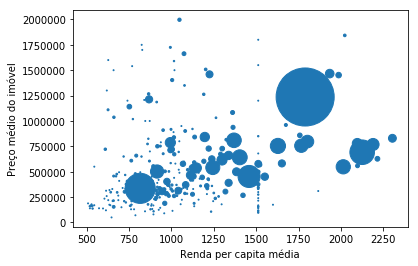

In [7]:
df_corr = base_limpa[['city_name', 'state_name','Renda', 'price']]
df_corr = df_corr.groupby('city_name').agg({'Renda':['mean', 'count'], 'price': ['mean']})
df_corr.columns = df_corr.columns.droplevel(0)
df_corr.columns = ['media_renda', 'qtdd', 'media_price']
df_corr = df_corr[~df_corr.media_renda.isnull()]
df_corr = df_corr[df_corr.media_price<2000000]
plt.scatter(df_corr.media_renda, df_corr.media_price, s=df_corr.qtdd)
plt.xlabel('Renda per capita média')
plt.ylabel('Preço médio do imóvel')
plt.show()

In [8]:
pd.set_option('display.max_colwidth', -1) #mostrar todo o conteudo do dataframe (util p/ campo descrição)
#pd.set_option('display.max_colwidth', -1) #default

#  Árvore de Regressão

In [8]:
base_limpa

,property_id,created_on,property_type,place_name,state_name,surface_covered_in_m2,rooms,description,title,price,city_name,piscina,vagas,suites,Cidade,Renda
0,c0891dfedd0e009083a1e427240a47f527a2a9c3,2015-04-29,house,Vila das Mercês,São Paulo,130.0,4.0,"Belíssimo sobrado vago em condomínio fechado com portaria 24 horas, contem : 4 dormitórios sendo 1 suíte, sala 2 ambientes, cozinha, quintal com churrasqueira, 2 vagas, ótima localização próximo a supermercados, bancos e farta condução. agende já.","Casa com 4 quartos e Salas, São Paulo, Vila das Mercês, por R$ 550.000",550000,São Paulo,0,2.0,1.0,São Paulo,1789.02
1,6fcb2f8e7c0afe7a5a4d2fa51fa6b29186dad37d,2015-06-01,house,Tarumã,São Paulo,169.0,3.0,"Excelente Sobrado Novo em condomínio fechado com 3 suítes (sendo 1 master), sala com 3 ambientes + home theather + escritório + despensa + área de churrasqueira/estacionamento + deck com vista para a mata (há um parque nos fundos do terreno) + quarto de empregada.Piso na sala/cozinha/banheiros de porcelanato primeira linha e no quartos/closet piso laminado.Casa está pronta, faltando apenas terminar o jardim.Financia e aceita terreno até R$ 130 mil como parte de pagamento.","Casa, Santana de Parnaíba, Tarumã, por R$ 850.000",850000,Santana de Parnaíba,0,1.0,3.0,Santana de Parnaíba,1986.36
2,e261163e6e404a1dc9acb1d624fb3ad84d63d3c9,2015-05-21,house,Brooklin Paulista,São Paulo,169.0,5.0,"Sobrado com 5 dormitórios, sendo 4 suítes, (1 suíte master com closet), sala para ambientes em L com lareira, no piso intermediário, temos copa/cozinha com armários,escritório, mais 1 quarto e despensa, no piso térreo temos a churrasqueira, banheiro, salão de festas e quintal, são 3 vagas de garagem e quintal. A casa está parcialmente reformada, precisa de pequena reforma, casa ampla, bem localizada, rua bastante tranquila, bem arborizada, com vista permanente para a chácara flora, fácil acesso as principais avenidas: Av. Washington Luiz, Av. Vereador José Diniz, Av. Santo Amaro.","Casa, São Paulo, Brooklin Paulista, por R$ 1.880.000",1880000,São Paulo,0,3.0,4.0,São Paulo,1789.02
3,9c0d8b0ae7b5e0ea90c1d907eb6fdfcc374baa46,2015-07-19,house,Jardim Prudência,São Paulo,169.0,4.0,"Se você não conhece se surpreenda com Jardim Prudência, excelente localização, arborizado, bem residencial, com lindas casas e muita vida saudável. Belo sobrado com fachada moderna, reformado, com purificador de água na entrada da Sabesp, área construída 450m2, terreno 352m2 com 10m de frente, boa distribuição, ambientes amplos, acabamento de 1a qualidade, muito arejado, sala 3 ambientes, lavabo, 4 dormitórios sendo 2 suítes, amplos e lindos banheiros com luz natural. Fundos com salão e festas integrado à cozinha, churrasqueira e quintal, dependência de empregada. Aceita como parte de pagamento apto de bom padrão.","Casa, São Paulo, Jardim Prudência, por R$ 1.200.000",1200000,São Paulo,0,1.0,2.0,São Paulo,1789.02
4,1221da4aea3c485864d1801d553c3211316e8a14,2015-07-01,apartment,Parque Novo Mundo,São Paulo,80.0,3.0,"Otimo Imovel com o melhor valor da regiao, confira as fotos - apartamento com 3 dormitorios area de lazer completa armarios planejados no quarto do casal e na cozinha 1wc1 vaga lazer completo",Apartamento Em Sao Paulo,299000,São Paulo,0,1.0,1.0,São Paulo,1789.02
5,ce00b2324e356dcf85292a639e1bcde009d1430d,2015-04-09,house,Planalto Paulista,São Paulo,117.0,5.0,"ISOBRADO,TOTALMENTE REFORMADO, AMPLO SALÃO PODE SER DIVIDO EM 4 SALAS, ESCRITÓRIO, WC E TERRAÇO. ÓTIMO ACABAMENTO, HIDRÁULICA, ELÉTRICA. FIANCIE USE O FGTS, Piso térreo: amplo salão que pode ser dividido em 2 ou 3 salas escritório, 2 wc, copa/cozinha, entrada lateral e lavanderia-1 andar: amplo salão que pode ser divido em 4 salas, escritório, wc e terraço. ótimo acabamento, 1 quadra do retorno, marca uma visita.","Casa com 3 quartos e 5 Salas, São Paulo, Planalto Paulista, por R$ 650.000",650000,São Paulo,0,1.0,1.0,São Paulo,1789.02
6,d4c82db74500a48b67da4e04c5e2580d4c7a4a60,2015-06-26,apartment,Marechal Rondon,Rio 

In [18]:
#processamento nos dados para transformar variavel categorica em numerica
dados = pd.get_dummies(base_limpa[['property_type', 'surface_covered_in_m2', 'rooms', 'vagas', 'piscina', 'suites', 'Renda']])
resultados = base_limpa.price
Xtrain, Xtest, Ytrain, Ytest = train_test_split(dados, resultados) # 75% para treino e 25% para teste


In [19]:
model = tree.DecisionTreeRegressor()
# Treina o modelo usando os dados de treino e de teste confere o score
model.fit(Xtrain, Ytrain)
model.score(Xtrain, Ytrain)

0.45166634073596323

In [20]:
#Prevê o resultado
predicted= model.predict(Xtest)

In [21]:
df_new = Xtest.copy()
df_new['price'] = Ytest 
df_new['price_pred'] = predicted
df_new.price_pred = df_new.price_pred.astype(int)

In [22]:
df_new

,surface_covered_in_m2,rooms,vagas,piscina,suites,Renda,property_type_PH,property_type_apartment,property_type_house,property_type_store,price,price_pred
282,80.0,4.0,1.0,1,4.0,994.29,0,1,0,0,3000000,2060671
5762,80.0,2.0,1.0,0,1.0,1789.02,0,1,0,0,3100000,1425095
9623,136.0,4.0,1.0,0,2.0,1789.02,0,0,1,0,1500000,827000
5340,169.0,3.0,3.0,1,1.0,2125.19,0,0,1,0,545000,840000
3413,169.0,2.0,1.0,0,1.0,1789.02,0,0,1,0,550000,752789
1732,169.0,4.0,1.0,1,1.0,935.11,0,0,1,0,1350000,800000
7751,156.0,2.0,3.0,0,2.0,1369.48,0,1,0,0,783000,638000
2280,80.0,2.0,1.0,0,1.0,2189.41,0,1,0,0,400000,561611
8042,77.0,2.0,1.0,0,1.0,1789.02,0,1,0,0,450000,669428
8211,45.0,1.0,1.0,1,1.0,868.87,0,1,0,0,243000,160000


In [23]:
Xtrain

,surface_covered_in_m2,rooms,vagas,piscina,suites,Renda,property_type_PH,property_type_apartment,property_type_house,property_type_store
5417,169.0,1.0,1.0,0,1.0,1040.980000,0,0,1,0
9503,180.0,4.0,1.0,0,1.0,678.310000,0,0,1,0
7731,197.0,3.0,1.0,1,1.0,994.290000,0,0,1,0
2551,80.0,2.0,2.0,0,1.0,1789.020000,0,1,0,0
2229,54.0,2.0,1.0,0,1.0,2125.190000,0,1,0,0
5371,115.0,1.0,1.0,0,1.0,1458.490000,0,1,0,0
5377,50.0,2.0,1.0,0,1.0,1458.490000,0,1,0,0
2631,169.0,3.0,1.0,1,3.0,1244.550000,0,0,1,0
6763,149.0,3.0,1.0,0,1.0,1789.020000,0,0,1,0
9820,57.0,2.0,1.0,1,1.0,804.740000,0,0,1,0


# SVR (Support Vector Regression)

In [9]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [10]:
base_limpa.head(n=1)

,property_id,created_on,property_type,place_name,state_name,surface_covered_in_m2,rooms,description,title,price,city_name,piscina,vagas,suites,Cidade,Renda
0,c0891dfedd0e009083a1e427240a47f527a2a9c3,2015-04-29,house,Vila das Mercês,São Paulo,130.0,4.0,"Belíssimo sobrado vago em condomínio fechado com portaria 24 horas, contem : 4 dormitórios sendo 1 suíte, sala 2 ambientes, cozinha, quintal com churrasqueira, 2 vagas, ótima localização próximo a supermercados, bancos e farta condução. agende já.","Casa com 4 quartos e Salas, São Paulo, Vila das Mercês, por R$ 550.000",550000,São Paulo,0,2.0,1.0,São Paulo,1789.02


In [87]:
#processamento nos dados para transformar variavel categorica em numerica
dados_svr = pd.get_dummies(base_limpa[['property_type', 'surface_covered_in_m2', 'rooms', 'vagas', 'piscina', 'suites', 'Renda']])
#dados_svr = base_limpa[['property_id','created_on','property_type','place_name','state_name','surface_covered_in_m2','rooms','description','title','city_name','piscina','vagas','suites','Cidade','Renda']]
resultados_svr = base_limpa.price
Xtrain_svr, Xtest_svr, Ytrain_svr, Ytest_svr= train_test_split(dados_svr, resultados_svr) # 75% para treino e 25% para teste

In [88]:
#dados_svr.info()#[['surface_covered_in_m2','rooms','vagas','piscina','suites','Renda']]
dados_svr

,surface_covered_in_m2,rooms,vagas,piscina,suites,Renda,property_type_PH,property_type_apartment,property_type_house,property_type_store
0,130.0,4.0,2.0,0,1.0,1789.02,0,0,1,0
1,169.0,3.0,1.0,0,3.0,1986.36,0,0,1,0
2,169.0,5.0,3.0,0,4.0,1789.02,0,0,1,0
3,169.0,4.0,1.0,0,2.0,1789.02,0,0,1,0
4,80.0,3.0,1.0,0,1.0,1789.02,0,1,0,0
5,117.0,5.0,1.0,0,1.0,1789.02,0,0,1,0
6,80.0,3.0,1.0,0,1.0,1084.78,0,1,0,0
7,80.0,3.0,1.0,0,1.0,1784.44,0,1,0,0
8,80.0,3.0,1.0,0,1.0,1784.44,0,1,0,0
9,50.0,0.0,1.0,0,1.0,1369.48,0,0,0,1


In [89]:
model_svr = SVR(kernel='rbf', gamma='auto', C=10, epsilon=0.1)
model_svr.fit(Xtrain_svr, Ytrain_svr)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [90]:
pred_scr = model_svr.predict(Xtest_svr)

In [91]:
r2_score(Ytest_svr.values, pred_scr)

-0.07730122932163974

In [92]:
model_svr.score(Xtest_svr, pred_scr)

1.0

In [93]:
df_t = pd.DataFrame()
df_t['Yt'] = Ytest_svr.values
df_t['p'] = pred_scr
df_t

,Yt,p
0,599000,493172.092733
1,1100000,490297.680130
2,312600,489552.598347
3,1950000,490453.386348
4,447683,489507.406696
5,329000,488932.379506
6,2850000,489894.059000
7,180000,489588.168527
8,200000,489579.108814
9,437000,489560.928446


# Linear regression

In [97]:
regr= LinearRegression().fit(Xtrain_svr, Ytrain_svr)
regr.score(Xtest_svr, Ytest_svr)

0.1901836662060764

In [95]:
p = regr.predict(Xtest_svr)

In [96]:
r2_score(Ytest_svr, p)

0.1901836662060764